# AIS GBM
---
## General Remarks <br>

+ The development of this Python script is mainly done with Jupyter notebook <br>
+ The script is run with Python 3.9.15<br>
+ Running time using ``AMD Ryzen 2700X, 16GB RAM``, 20 Minutes 

---

##  Specific to `AIS_BBM`

+ This part of the script focus on BBM side of the GBM
+ Initial data pre-processing, model training and hyperparameter optimisation is performed with this script
+ Please remember to .gitignore the model generated using this script, as the file size can be quite big

---

### Package initialisation

+ Standard packages for ML is loaded 
+ The `joblib` package is used to save the generated model

In [295]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import pickle
import joblib
import time 

### Data preprocessing :

+ Two data sources will be imported 
+ `AIS_weather_h_rename_copy.csv` will be used to complement the information for _true current direction_ and _true wind direction_ 
+ The resulting dataframe will be merged with the dataframe from the `AIS_weather_H_ok2_copy.csv` 
+ The data of the journey between Ronne and Sassnitz will be omitted, the filter is applied at 55.04°



In [296]:
# Parameter to plot in latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

# Load the data to the script

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]


dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [297]:
# Check for missing datapoints in dataset
print(dfmain.info())
print(dfpre.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            7453 non-null   int64         
 1   Time                                  7453 non-null   datetime64[ns]
 2   LON                                   7453 non-null   float64       
 3   LAT                                   7453 non-null   float64       
 4   Temperature above oceans              7453 non-null   float64       
 5   Air density above oceans              7337 non-null   float64       
 6   Max wave height                       6274 non-null   float64       
 7   Swell period                          6274 non-null   float64       
 8   Wind wave period                      6274 non-null   float64       
 9   Wave period                           6274 non-null   float64       
 10  

#### Histogram to show anomalies
+ The SOG is not per se anomalies, but the lower speed range may heavily affect the trained model, as the data are clustered at SOG = 0 kt
+ However for current speed, it is indeed anomaly, as this show abnornmal peak 

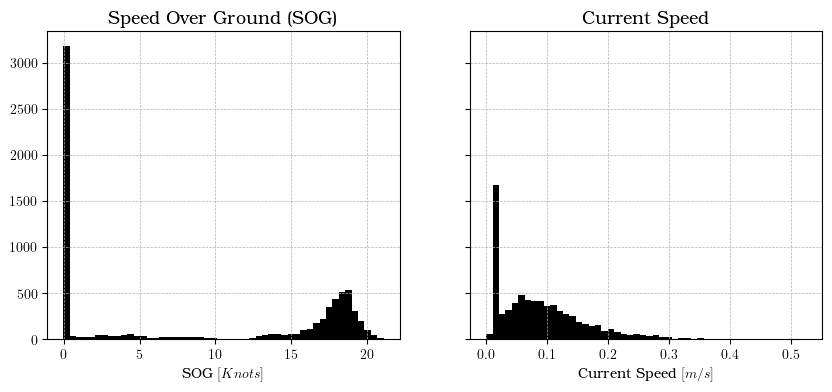

In [298]:
# Anomalies plot

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
dfmain['SOG'].hist(bins=50,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"SOG $[Knots]$")
plt.title(r"Speed Over Ground (SOG)", fontsize=13)
plt.sca(axes[1])
dfmain['Current Speed'].hist(bins=50,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"Current Speed $[m/s]$")
plt.title(r"Current Speed", fontsize=13)
plt.ylabel("")
plt.show()

### Calculation of ship's true north wind and current direction

+ All features are dropped except for `eastwind`, `northwind`, `eastcurrent`, `northcurrent` , `sog` and `cog`

In [299]:
# Drop all dulplicate feature in dataset "AIS_weather_h_rename_copy.csv"

dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 

### Imputing missing values using `KNNImputer`
+ The dataset is first imputed
+ Then it is transformed

In [300]:
# Imputing the information for the missing east and north current data

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [301]:
# Transform
x_pre = imputer.transform(dfpre)

### Calculation of true north current and true north wind
+ The current and wind speed can be calculated using pythagoras theorem
+ The current and wind direction is divided into several conditions to ensure that they belong to the suitable quadrants

In [302]:
# Ensure that the imputed value maintains the same column heading 
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [303]:
# Calculate current and wind speed
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [304]:
# Calculate the True North wind direction and split them into quadrants

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))

In [305]:
# Calculate the True North current direction and split them into quadrants
condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [306]:
# Drop further unecessary feature before merging to main dataset
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [307]:
# Drop the wind speed and current speed from the original dataset as it contains outlier 
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [308]:
# Combine the the information of true north to main dataset
df = pd.concat([dfmain,dfpre],axis=1)

### SOG threshold
+ The threshold for the ships manouvering speed will be 5 knots ([Abebe20](https://doi.org/10.3390/app10072325),[Yan21](https://doi.org/10.1016/j.tre.2020.101930))
+ Alternatively, outlier rejection using &mu; &plusmn; 3&sigma; ([Gkerekos19](https://doi.org/10.1016/j.oceaneng.2019.106282)), this should increase the threshold to about 8 knots

In [309]:
# SOG threshold according to Abebe20 and Yan21

df = df[df['SOG'] > 5 ]

# # SOG threshold according to Gkerekos19

# df = df[df['SOG'] > 8 ]

In [310]:
# Length of dataset after speed filter
print(f"Length of speed filter dataset {len(df)}")

Length of speed filter dataset 3828


### Data split into training and test
+ The `random_state` is 42, however to gain different datasets, change the `random_state` to other numbers (arbitrary)

In [311]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.25, random_state=42)

In [312]:
# re-declare that df will be the dataframe used for training 
df = train_set

In [313]:
# Length of test dataset
print(f"Length of train dataset {len(train_set)}")
print(f"Length of test dataset {len(test_set)}")

Length of train dataset 2871
Length of test dataset 957


### Data Analysis before modelling
+ The steps in this section include: 
    + Feature deletion
    + Feature correlation 
    + Feature deletion 
+ The test dataset will also be preprocessed so for various plots of learning curves and HPO exploration
    

In [314]:
# # Remove features that have no impact on model training

# df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
#                     'Surface pressure','Width','Length'],axis=1)

# test_set = test_set.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
#                     'Surface pressure','Width','Length'],axis=1)

In [315]:
df_ship = df.drop(['Unnamed: 0','Time','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)

test_set = test_set.drop(['Unnamed: 0','Time','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)

In [316]:
# Renaming Features 

df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

test_set2 = test_set.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [317]:
# df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

# test_set2 = test_set2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]


In [318]:
df_ship2 = df_ship2[['LON','LAT','oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

test_set2 = test_set2[['LON','LAT','oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

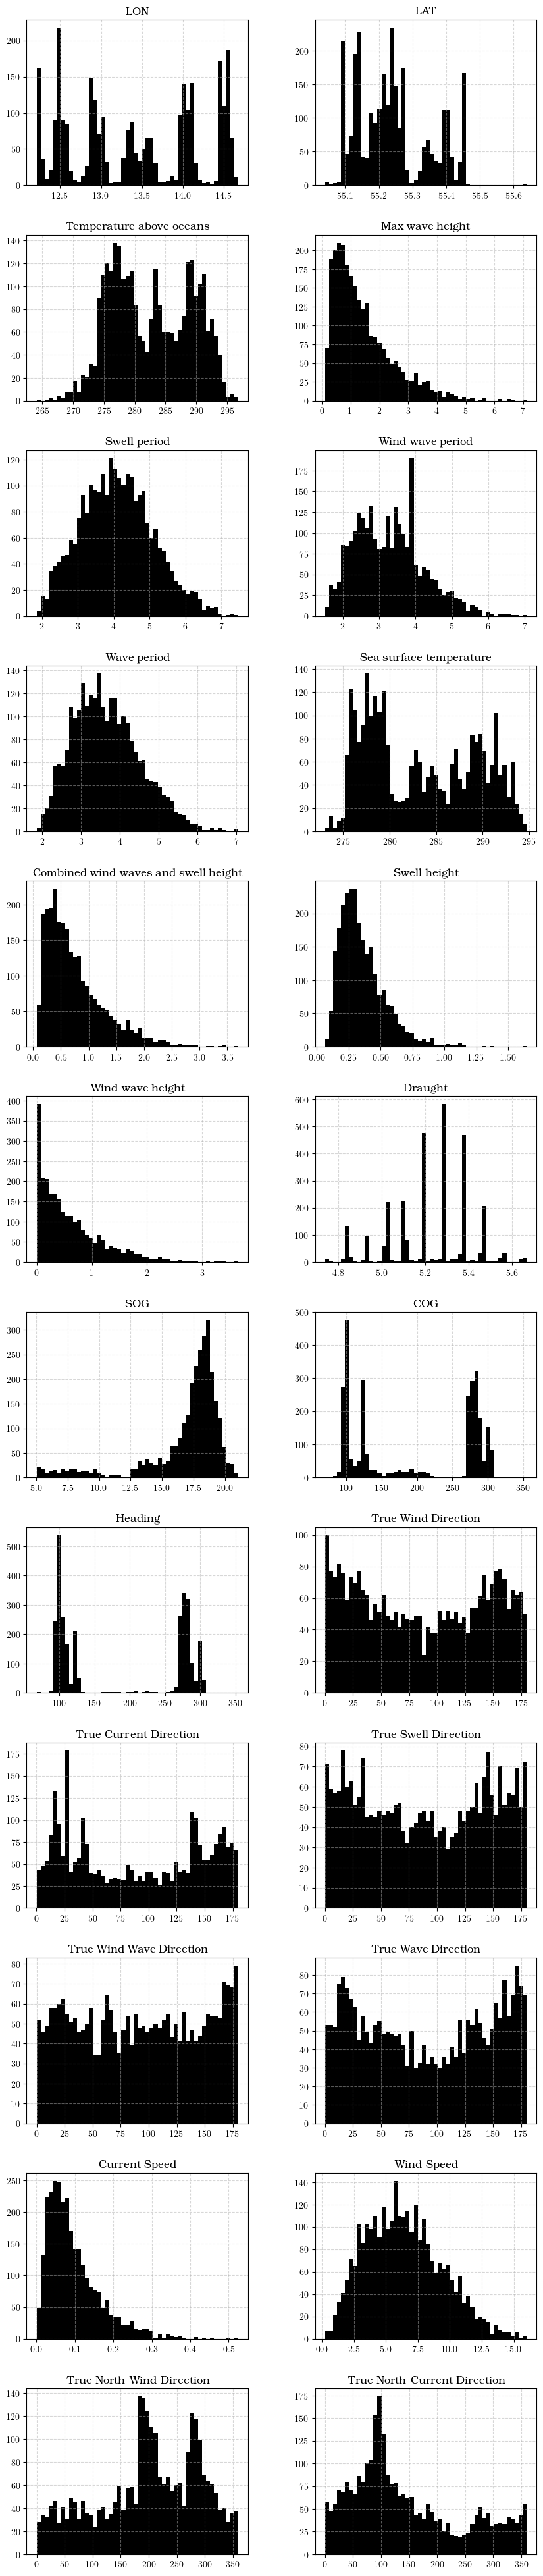

In [319]:
# Histogram plot of pre processed training dataset

# plt.rcParams.update(plt.rcParamsDefault) # Alter default value 
axes = df_ship.hist(bins=50,figsize=(10,50),color='black',grid=True,layout=(12,2))
for ax in axes.flatten():
    ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [320]:
# Drop variables such as date from the dataset

dfship_corr = df_ship2.drop(df_ship2.columns[[0,5,15,16,17,18,19,20,21]],axis=1)
print(dfship_corr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2871 entries, 984 to 6608
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   LAT                  2871 non-null   float64
 1   oceantemperature     2871 non-null   float64
 2   waveheight           2573 non-null   float64
 3   swellperiod          2573 non-null   float64
 4   waveperiod           2573 non-null   float64
 5   surftemp             2772 non-null   float64
 6   windwaveswellheight  2573 non-null   float64
 7   swellheight          2573 non-null   float64
 8   windwaveheight       2573 non-null   float64
 9   draught              2871 non-null   float64
 10  sog                  2871 non-null   float64
 11  cog                  2871 non-null   float64
 12  heading              2871 non-null   float64
 13  truenorthwinddir     2871 non-null   float64
 14  truenorthcurrentdir  2871 non-null   float64
dtypes: float64(15)
memory usage: 358.9 K

In [321]:
# Function to plot correlation heatmap
def correlation_heatmap(df,fontsize):
    correlations = df.corr()
    # Parameter to plot in nice latex fonts
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    colormap = sns.color_palette("Reds")
    fig, ax = plt.subplots(figsize=(10,10))
    sns.set(font_scale = fontsize)
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',cmap="mako",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
                # ,annot_kws={'fontsize': 12, 'color':'k', 'alpha': 1})
    plt.show();

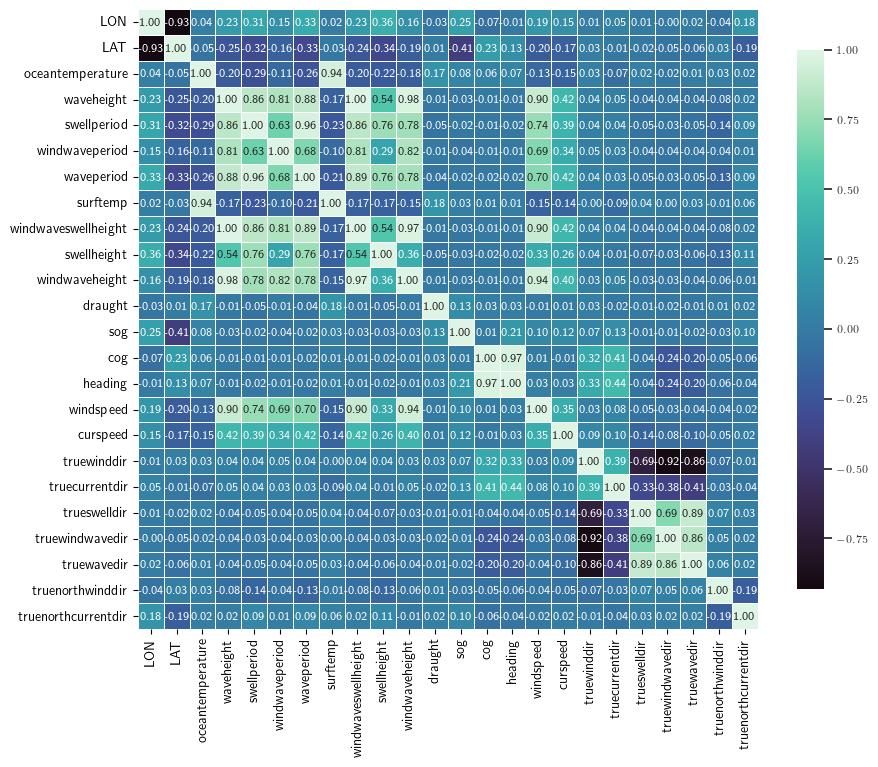

In [322]:
# Heatmap plot of overall dataset

df_ship_ovr = df_ship2
correlation_heatmap(df_ship_ovr,.7)

### Scientific Justification of High Correlation Filter [Abebe20](https://doi.org/10.3390/app10072325):

- According to [BitnerGregersen05](https://doi.org/10.1115/OMAE2005-67382), the wind wave swell height is equal to the square root of the square of swell wave and wind wave. Therefore Swell Wave Height and Wind Wave Height is dropped.
- According to [Bretschneider65](https://apps.dtic.mil/sti/citations/ad0612006), the max wave height is 2*H<sub>(1/3)</sub>. This correlation means that maximum wave height, `waveheight` is dropped
- According to [Torsetshaugen04](https://www.semanticscholar.org/paper/Simplified-Double-Peak-Spectral-Model-For-Ocean-Torsethaugen-Haver/0f1b1509791d441861ff6c2940dd13b1f939f149), The type of dominating wave (Wind wave/Swell) can be predicted from an equation which include the significant wave height and a certain threshold, therefore, it is decided that the `windwaveperiod`, ``swellperiod`` and consequently the ``truewindwavedirection`` and ``trueswell direction`` is to be dropped.
- `truenorthdirection` carries less significance, instead the `truedirections` are used which is direction of weather effect w.r.t. the ship bow

In [323]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truenorthcurrentdir','truenorthwinddir'],axis=1)

test_set2 = test_set2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truenorthcurrentdir','truenorthwinddir'],axis=1)

In [324]:
# df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
#                         'windwaveperiod','swellperiod',
#                         'truewindwavedir','trueswelldir',
#                         'truenorthcurrentdir','truenorthwinddir','cog','heading'],axis=1)

# test_set2 = test_set2.drop(['waveheight','swellheight','windwaveheight',
#                         'windwaveperiod','swellperiod',
#                         'truewindwavedir','trueswelldir',
#                         'truenorthcurrentdir','truenorthwinddir','cog','heading'],axis=1)

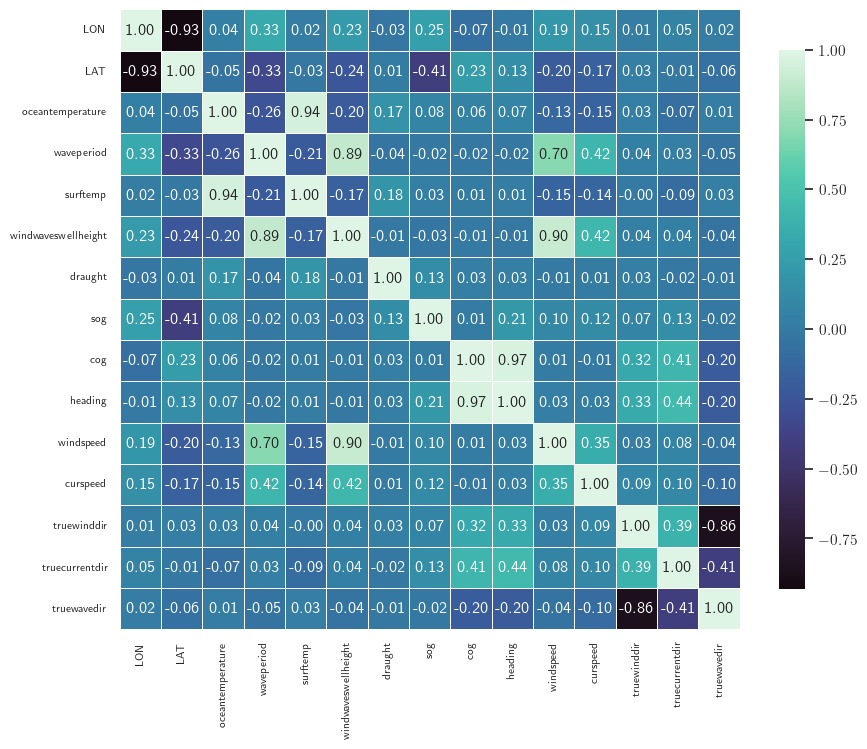

In [325]:
# Heatmap for training feature

correlation_heatmap(df_ship2,1)

In [326]:
# # demonstrate how to toggle the display of different elements:
# # Histogram plot of final features and labels for training

# fs = 10

# plt.rcParams.update(plt.rcParamsDefault)
# # Parameter to plot in nice latex fonts
# plt.rcParams.update({
# 	"text.usetex": True,
# 	"font.family": "serif",
# 	"font.serif": "bookman",
# 	})

# oceantemp = df_ship2['oceantemperature']
# waveperiod = df_ship2['waveperiod']
# surftemp = df_ship2['surftemp']
# sigwave = df_ship2['windwaveswellheight']
# draught = df_ship2['draught']
# sog = df_ship2['sog']
# cog = df_ship2['cog']
# hdg = df_ship2['heading']
# windspeed = df_ship2['windspeed']
# curspeed = df_ship2['curspeed']
# truewavedir = df_ship2['truewavedir']
# truewind = df_ship2['truewinddir']
# truecurrent = df_ship2['truecurrentdir']

# fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

# axes[0, 0].hist(oceantemp,bins=25,color='black')
# axes[0, 0].set_title(r'Air Temperature above Oceans $[K]$', fontsize=fs)
# axes[0, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[0, 1].hist(surftemp,bins=25,color='black')
# axes[0, 1].set_title(r'Sea Surface Temperature $[K]$', fontsize=fs)
# axes[0, 1].grid(True,linestyle = '--', linewidth = 0.5)

# axes[0, 2].hist(waveperiod,bins=25,color='black')
# axes[0, 2].set_title(r'Wave Period $[s]$', fontsize=fs)
# axes[0, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[1, 0].hist(sigwave,bins=25,color='black')
# axes[1, 0].set_title(r'Significant Wave Height $[m]$', fontsize=fs)
# axes[1, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[1, 1].hist(draught  ,bins=25,color='black')
# axes[1, 1].set_title(r'Draught $[m]$', fontsize=fs)
# axes[1, 1].grid(True,linestyle = '--', linewidth = 0.5)

# axes[1, 2].hist(truewavedir,bins=25,color='black')
# axes[1, 2].set_title(r'True Wave Direction $[deg]$', fontsize=fs)
# axes[1, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[2, 0].hist(cog,bins=25,color='black')
# axes[2, 0].set_title(r'Course Heading $[deg]$', fontsize=fs)
# axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[2, 1].hist(curspeed,bins=25,color='black')
# axes[2, 1].set_title(r'Current Speed $[m/s]$', fontsize=fs)
# axes[2, 1].grid(True,linestyle = '--', linewidth = 0.5)

# axes[2, 2].hist(windspeed,bins=25,color='black')
# axes[2, 2].set_title(r'Wind Speed $[m/s]$', fontsize=fs)
# axes[2, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 0].hist(hdg,bins=25,color='black')
# axes[3, 0].set_title(r'Heading $[deg]$', fontsize=fs)
# axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 1].hist(truecurrent,bins=25,color='black')
# axes[3, 1].set_title(r'True Current Direction $[deg]$', fontsize=fs)
# axes[3, 1].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 2].hist(truewind,bins=25,color='black')
# axes[3, 2].set_title(r'True Wind Direction $[deg]$', fontsize=fs)
# axes[3, 2].grid(True,linestyle = '--', linewidth = 0.5)

# fig.subplots_adjust(hspace=0.4)
# plt.show()

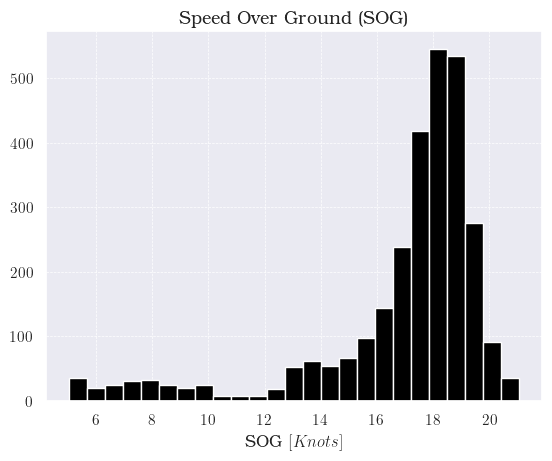

In [327]:
# Profile of SOG 

df_ship2['sog'].hist(bins=25,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"SOG $[Knots]$")
plt.title(r"Speed Over Ground (SOG)", fontsize=13)
plt.show()

### Imputing using KNN so that the all tree-based model by Sklearn may function 
+ The model by sklearn cannot accept `nan` values 
+ The imputing process is the same
    + Impute
    + Transform
    + Column heading matches the heading before imputing

In [328]:
# Impute for training data 

import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)

# Transform

X = imputer.transform(df_ship2)

# Set heading to make sure they have same name 

df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [329]:
# Impute for testing data

imputer_tst = KNNImputer(n_neighbors=50)
imputer_tst.fit(test_set2)

# Transform

Xtest = imputer_tst.transform(test_set2)

# Set heading to make sure they have same name 

test_set2tr = pd.DataFrame(Xtest, columns=test_set2.columns, index=test_set2.index)

In [330]:
# Final check to ensure that the data points are all the same

print(df_ship2tr.info())
print(test_set2tr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2871 entries, 984 to 6608
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   LON                  2871 non-null   float64
 1   LAT                  2871 non-null   float64
 2   oceantemperature     2871 non-null   float64
 3   waveperiod           2871 non-null   float64
 4   surftemp             2871 non-null   float64
 5   windwaveswellheight  2871 non-null   float64
 6   draught              2871 non-null   float64
 7   sog                  2871 non-null   float64
 8   cog                  2871 non-null   float64
 9   heading              2871 non-null   float64
 10  windspeed            2871 non-null   float64
 11  curspeed             2871 non-null   float64
 12  truewinddir          2871 non-null   float64
 13  truecurrentdir       2871 non-null   float64
 14  truewavedir          2871 non-null   float64
dtypes: float64(15)
memory usage: 358.9 K

### Preparation of Training data
+ SOG as target variable
+ Rest as feature

In [331]:
x_train = df_ship2tr.drop(['sog'],axis=1)
y_train = df_ship2tr.sog

x_test = test_set2tr.drop(['sog'],axis=1)
y_test = test_set2tr.sog

In [332]:
print("Amount of the x training dataset are:",len(x_train))

Amount of the x training dataset are: 2871


In [333]:
print("Amount of x test dataset are",len(x_test))

Amount of x test dataset are 957


In [334]:
# Descriptive statistics of the features
print(x_train.describe())

               LON          LAT  oceantemperature   waveperiod     surftemp  \
count  2871.000000  2871.000000       2871.000000  2871.000000  2871.000000   
mean     13.418892    55.242353        282.711463     3.656496   283.402582   
std       0.781444     0.107186          6.490218     0.822044     5.733835   
min      12.213701    55.040170        264.076782     1.857891   273.048584   
25%      12.612303    55.143856        277.132385     3.073893   278.129395   
50%      13.380683    55.231003        282.624023     3.569214   282.833252   
75%      14.093915    55.326905        288.823120     4.139376   288.861084   
max      14.674737    55.639000        296.830322     7.047197   294.751709   

       windwaveswellheight      draught          cog      heading  \
count          2871.000000  2871.000000  2871.000000  2871.000000   
mean              0.749238     5.224037   196.472472   187.875727   
std               0.505370     0.180681    85.932980    88.470768   
min         

In [335]:
# Descriptive statistics of target variable
print(y_train.describe())

count    2871.000000
mean       16.913445
std         3.176740
min         5.027200
25%        16.561214
50%        17.936689
75%        18.718229
max        21.070514
Name: sog, dtype: float64


In [336]:
# Cross check with WBM to ensure that the test dataset has the same characteristics
print(x_test.describe())

              LON         LAT  oceantemperature  waveperiod    surftemp  \
count  957.000000  957.000000        957.000000  957.000000  957.000000   
mean    13.428703   55.239449        282.279440    3.686927  283.195393   
std      0.764546    0.105891          6.475851    0.882364    5.717368   
min     12.217122   55.056343        267.245300    1.672565  273.151367   
25%     12.857662   55.146454        276.796387    3.061307  277.980225   
50%     13.397246   55.228287        281.913574    3.552264  282.650024   
75%     14.079568   55.277420        288.423340    4.219748  288.822632   
max     14.676100   55.609090        295.699951    7.014300  294.928223   

       windwaveswellheight     draught         cog     heading   windspeed  \
count           957.000000  957.000000  957.000000  957.000000  957.000000   
mean              0.765754    5.227477  196.729343  188.300965    6.450577   
std               0.543002    0.185996   86.724148   89.168377    3.047510   
min         

In [337]:
print(y_test.describe())

count    957.000000
mean      16.992892
std        3.098953
min        5.104109
25%       16.682544
50%       18.054214
75%       18.716411
max       21.005331
Name: sog, dtype: float64


## Model Training
+ One model is trained with default hyperparameter (HP)
+ Other is optimised (HPO)

Modelling using Random Forest Regressor 

In [338]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr = RandomForestRegressor(random_state=42)
start_rf = time.time()
model_rfr_ftr.fit(x_train,y_train)
end_rf = time.time()
print(f"Training time: {end_rf-start_rf:0.4}s ")

Training time: 5.199s 


HPO RFR

In [339]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr_hpov = RandomForestRegressor(n_estimators = 100,
                                            min_samples_split = 2,
                                            min_samples_leaf = 1,
                                            max_features = 10,
                                            max_depth=120,
                                            random_state=42)

# # Prev HPO: (n_estimators = 900,min_samples_split = 2,min_samples_leaf = 2,# max_features = 9,max_depth=200,random_state=42)

start_rfo = time.time()
model_rfr_ftr_hpov.fit(x_train,y_train)
end_rfo = time.time()
print(f"Training time: {end_rfo-start_rfo:0.4}s ")

Training time: 3.801s 


Modelling using ETR

In [340]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr = ExtraTreesRegressor(random_state=42)
start_et = time.time()
model_etr.fit(x_train,y_train)
end_et = time.time()
print(f"Training time: {end_et-start_et:0.4}s ")

Training time: 1.056s 


HPO ETR

In [341]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr_hpov = ExtraTreesRegressor(random_state=42,
                                n_estimators=800,
                                min_samples_split=9,
                                min_samples_leaf=1,
                                max_features=12,
                                max_depth=120,
                                )

start_eto = time.time()
model_etr_hpov.fit(x_train,y_train)
end_eto = time.time()
print(f"Training time: {end_eto-start_eto:0.4}s")

Training time: 4.362s


Modelling using Decision Tree Regressor

In [342]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor()
start_dtr = time.time()
model_dtr.fit(x_train,y_train)
end_dtr = time.time()
print(f"Training time: {end_dtr-start_dtr:0.4}s")

Training time: 0.05101s


HPO DTR 

In [343]:
from sklearn.tree import DecisionTreeRegressor
model_dtr_hpov = DecisionTreeRegressor(min_samples_split=7,
                                  min_samples_leaf=10,
                                  max_features=12,
                                  max_depth=8)
# Old HPO (min_samples_split=2,min_samples_leaf=3,max_features=12,max_depth=10)
start_dtro = time.time()
model_dtr_hpov.fit(x_train,y_train)
end_dtro = time.time()
print(f"Training time: {end_dtro-start_dtro:0.4}s")

Training time: 0.02301s


Modelling using Multiple Linear Regression

In [344]:
from sklearn import linear_model
model_mlr = linear_model.LinearRegression()
start_mlr = time.time()
model_mlr.fit(x_train,y_train)
end_mlr = time.time()
print(f"Training time: {end_mlr-start_mlr:0.4}s")

Training time: 0.004s


Save model to local directory
+ Uncomment this section if you are already satisfied with your model performance after performing HPO
+ Do not forget to add `.gitignore` for the `.sav` extensions !
+ Change the name to your liking at filename 

In [345]:
# # # Saving the model to local directory

# filename = 'savemodel_rfr_ftr.sav'
# joblib.dump(model_rfr_ftr,filename)

# filename = 'savemodel_rfr_ftr_hpov.sav'
# joblib.dump(model_rfr_ftr_hpov,filename)

# filename = 'savemodel_etr.sav'
# joblib.dump(model_etr,filename)

# filename = 'savemodel_etr_hpov.sav'
# joblib.dump(model_etr_hpov,filename)

# filename = 'savemodel_dtr_ftr.sav'
# joblib.dump(model_dtr,filename)

# filename = 'savemodel_dtr_hpov.sav'
# joblib.dump(model_dtr_hpov,filename)

# filename = 'savemodel_mlr_ftr.sav'
# joblib.dump(model_mlr,filename)

In [346]:
from sklearn.inspection import permutation_importance

permu_rest = permutation_importance(model_rfr_ftr_hpov,x_train,y_train,n_repeats=5,random_state=42)

permu_rest.importances_mean
permu_rest.importances_std

array([1.34935940e-02, 2.55825987e-02, 2.87706148e-05, 1.72835767e-04,
       8.55994417e-05, 9.15144112e-05, 1.17144040e-03, 9.20604342e-04,
       5.97060935e-04, 1.07170369e-04, 6.34617140e-05, 5.75321473e-05,
       3.13668227e-04, 4.27853892e-05])

In [347]:
def permu_importance(model_type,x_data,y_data):
    from sklearn.inspection import permutation_importance
    permu_rest = permutation_importance(model_type,x_data,y_data,n_repeats=10,random_state=42)
    permu_mean = permu_rest.importances_mean
    df_mod_imp = pd.DataFrame(permu_mean,index= x_train.columns,columns=["Importance"])
    print(df_mod_imp.sort_values(by=['Importance'],ascending=False))


In [348]:
permu_importance(model_rfr_ftr_hpov,x_train,y_train)

                     Importance
LON                    0.938660
LAT                    0.564843
cog                    0.041275
draught                0.034385
heading                0.016728
surftemp               0.004331
truecurrentdir         0.003942
curspeed               0.003844
waveperiod             0.003663
windwaveswellheight    0.003344
oceantemperature       0.003180
truewavedir            0.003062
windspeed              0.003011
truewinddir            0.002962


### Exploration of effect of different HP
+ Performed to save time on searching in unpromising areas
    + `max_features` : number of features considered when performing splits
    + ``min_samples_leaf`` : number of samples at leaf node
    + ``n_estimators`` : number of trees in a forest, irrelevant for DT
    + ``max_depth`` : controls the depth of the tree 
    + ``min_sample_split`` : minimum number of samples to split a node (minimal 2)
    ---

``max_features`` HPO

In [349]:
# # explore random forest number of features effect on performance, v2 optimised for comparison plot between decision tree and random forest
# def feature_curve(x,y,regressor,regname):
# 	from numpy import mean
# 	from numpy import std
# 	from sklearn.model_selection import cross_val_score
# 	from sklearn.model_selection import KFold

# 	plt.rcParams.update({
# 	"text.usetex": True,
# 	"font.family": "serif",
# 	"font.serif": "bookman",
# 	})

# 	# get a list of models to evaluate
# 	def get_modelsftr():
# 		models_ftr = dict()
# 		# explore number of features from 1 to 13
# 		for n in range(1,13):
# 			if regressor == 'dt':
# 				models_ftr[str(n)] = DecisionTreeRegressor(max_features=n)
# 			elif regressor == 'rf':
# 				models_ftr[str(n)] = RandomForestRegressor(max_features=n)
# 			elif regressor == 'et':
# 				models_ftr[str(n)] = ExtraTreesRegressor(max_features=n)	
# 		return models_ftr

# 	# evaluate a given model using cross-validation
# 	def evaluate_model(model, x, y):
# 		# define the evaluation procedure
# 		cv = KFold(n_splits=10, shuffle=True, random_state=1)
# 		# evaluate the model and collect the results
# 		scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# 		# negative scores due to scoring mechanism of sklearn
# 		return -scores

# 	# get the models to evaluate
# 	models_ftr = get_modelsftr()
# 	# evaluate the models and store results
# 	results_ftr, names_ftr = list(), list()
# 	for name, model in models_ftr.items():
# 		# evaluate the model
# 		scores_ftr = evaluate_model(model, x, y)
# 		# store the results
# 		results_ftr.append(scores_ftr)
# 		names_ftr.append(name)
# 		# summarize the performance along the way
# 		print('>%s %.3f (%.3f)' % (name, mean(scores_ftr), std(scores_ftr)))
	
# 	# Calculate mean for the x value of the plot

# 	mean_ftr = np.mean(results_ftr,axis=1)
# 	min_error_ftr = np.min(mean_ftr)

# 	print(f"The minimum MAE obtained is {min_error_ftr:.3f}")
	
# 	plt.plot(names_ftr,mean_ftr,"b.-")
# 	plt.grid(linestyle = '--', linewidth = 0.5)
# 	# plt.xlim(0,12-1)
# 	plt.ylim(0,2.5)
# 	plt.xlabel(r"Number of features",fontsize=13)
# 	plt.ylabel(r"MAE [knots]",fontsize=13)
# 	plt.title(rf"{regname}", fontsize=14)
# 	plt.boxplot(results_ftr, labels=names_ftr,positions=range(len(names_ftr)), showmeans=True)

In [350]:
# fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
# plt.sca(axes[0])
# feature_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
# plt.sca(axes[1])
# feature_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
# plt.ylabel("")
# plt.sca(axes[2])
# feature_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
# plt.ylabel("")
# plt.show()

``min_samples_leaf`` HPO

In [351]:
# # Investigate the effect of samples at leaf node
# def leaf_curve(x,y,regressor,regname):
# 	from numpy import mean
# 	from numpy import std
# 	from sklearn.model_selection import cross_val_score

# 	plt.rcParams.update({
# 	"text.usetex": True,
# 	"font.family": "serif",
# 	"font.serif": "bookman",
# 	})

# 	# get a list of models to evaluate
# 	def get_models_leaf():
# 		models_leaf = dict()
# 		# define number of trees to consider
# 		n_samples_leaf = [1,2,3,4,5,6,7,8,9,10,50]
# 		for n in n_samples_leaf:
# 			if regressor == 'dt':
# 				models_leaf[str(n)] = DecisionTreeRegressor(min_samples_leaf = n)
# 			if regressor == 'rf':
# 				models_leaf[str(n)] = RandomForestRegressor(min_samples_leaf = n)
# 			if regressor == 'et':
# 				models_leaf[str(n)] = ExtraTreesRegressor(min_samples_leaf = n)
# 		return models_leaf

# 	# evaluate a given model using cross-validation
# 	def evaluate_model(model, x, y):
# 		scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
# 		return -scores

# 	# # define dataset
# 	# get the models to evaluate
# 	models_leaf = get_models_leaf()

# 	# evaluate the models and store results
# 	results_leaf, names_leaf = list(), list()
# 	for name, model in models_leaf.items():
# 		# evaluate the model
# 		scores_leaf = evaluate_model(model, x, y)
# 		# store the results
# 		results_leaf.append(scores_leaf)
# 		names_leaf.append(name)
# 		# summarize the performance along the way
# 		print('>%s %.3f (%.3f)' % (name, mean(scores_leaf), std(scores_leaf)))


# 	mean_leaf = np.mean(results_leaf,axis=1)
# 	min_error_leaf = np.min(mean_leaf)
# 	print(min_error_leaf)
# 	bst_n_estimators_leaf = np.argmin(mean_leaf)
# 	print(f"The minimum MAE obtained is {min_error_leaf:.3f}")
# 	plt.plot(names_leaf,mean_leaf,"b.-")
# 	plt.grid(linestyle = '--', linewidth = 0.5)
# 	# plt.xlim(0,12-1)
# 	plt.ylim(0,2.5)
# 	plt.xlabel(r"Number of Samples in Leaf",fontsize=13)
# 	plt.ylabel(r"MAE [knots]",fontsize=13)
# 	plt.title(rf"{regname}", fontsize=14)
# 	plt.boxplot(results_leaf, labels=names_leaf,positions=range(len(names_leaf)), showmeans=True)

In [352]:
# fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
# plt.sca(axes[0])
# leaf_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
# plt.sca(axes[1])
# leaf_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
# plt.ylabel("")
# plt.sca(axes[2])
# leaf_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
# plt.ylabel("")
# plt.show()

``n_estimators`` HPO, irrelevant for DT

In [353]:
# # explore random forest and extra tree number of trees effect on performance
# def trees_curve(x,y,regressor,regname):
# 	from numpy import mean
# 	from numpy import std
# 	from sklearn.model_selection import cross_val_score

# 	plt.rcParams.update({
# 	"text.usetex": True,
# 	"font.family": "serif",
# 	"font.serif": "bookman",
# 	})

# 	# get a list of models to evaluate
# 	def get_models_tree():
# 		models_tree = dict()
# 		# define number of trees to consider
# 		n_trees = [1,10,100,200,300,400,500,600,700,800,900,1000]
# 		for n in n_trees:
# 			if regressor == 'rf':
# 				models_tree[str(n)] = RandomForestRegressor(n_estimators = n)
# 			elif regressor == 'et':
# 				models_tree[str(n)] = ExtraTreesRegressor(n_estimators = n)	
# 		return models_tree

# 	# evaluate a given model using cross-validation
# 	def evaluate_model(model_tree, x, y):
# 		scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
# 		return -scores

# 	# # define dataset
# 	# get the models to evaluate
# 	models_tree = get_models_tree()

# 	# evaluate the models and store results
# 	results_tree, names_tree = list(), list()
# 	for name, model in models_tree.items():
# 		# evaluate the model
# 		scores_tree = evaluate_model(model, x, y)
# 		# store the results
# 		results_tree.append(scores_tree)
# 		names_tree.append(name)
# 		# summarize the performance along the way
# 		print('>%s %.3f (%.3f)' % (name, mean(scores_tree), std(scores_tree)))


# 	mean_tree = np.mean(results_tree,axis=1)
# 	min_error_tree = np.min(mean_tree)
# 	print(min_error_tree)
# 	print(f"The minimum MAE obtained is {min_error_tree:.3f}")
# 	plt.plot(names_tree,mean_tree,"b.-")
# 	plt.grid(linestyle = '--', linewidth = 0.5)
# 	# plt.xlim(0,12-1)
# 	plt.ylim(0,2.5)
# 	plt.xlabel(r"Number of Trees", fontsize=13)
# 	plt.ylabel(r"MAE [knots]", fontsize=13)
# 	plt.title(rf"{regname}", fontsize=14)
# 	plt.boxplot(results_tree, labels=names_tree, showmeans=True,positions=range(len(names_tree)))


In [354]:
# fig, axes = plt.subplots(ncols=2, figsize=(12,8), sharey=True)
# plt.sca(axes[0])
# trees_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
# plt.sca(axes[1])
# trees_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
# plt.ylabel("")
# plt.show()

``max_depth`` HPO

In [355]:
# # explore tree based , tree depth. effect on performance
# def depth_curve(x,y,regressor,regname):
# 	from numpy import mean
# 	from numpy import std
# 	from sklearn.model_selection import cross_val_score
# 	from sklearn.model_selection import KFold

# 	# Parameter to plot in nice latex font

# 	plt.rcParams.update({
# 	"text.usetex": True,
# 	"font.family": "serif",
# 	"font.serif": "bookman",
# 	})

# 	# get a list of models to evaluate
# 	def get_models_dp():
# 		models_dp = dict()
# 		# consider tree depths from 1 to 7 and None=full
# 		depths = [1,2,3,4,5,6,7,8,9,10,100] + [None]
# 		for n in depths:
# 			if regressor == 'dt':
# 				models_dp[str(n)] = DecisionTreeRegressor(max_depth=n)
# 			elif regressor == 'rf':
# 				models_dp[str(n)] = RandomForestRegressor(max_depth=n)
# 			elif regressor == 'et':
# 				models_dp[str(n)] = ExtraTreesRegressor(max_depth=n)	
# 		return models_dp

# 	# evaluate a given model using cross-validation
# 	def evaluate_model(model, x, y):
# 		# define the evaluation procedure
# 		cv = KFold(n_splits=10, shuffle=True, random_state=1)
# 		# evaluate the model and collect the results
# 		scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# 		# negative scores due to scoring mechanism of sklearn
# 		return -scores

# 	# get the models to evaluate
# 	models_dp = get_models_dp()
# 	# evaluate the models and store results
# 	results_dp, names_dp = list(), list()
# 	for name, model in models_dp.items():
# 		# evaluate the model
# 		scores_dp = evaluate_model(model, x, y)
# 		# store the results
# 		results_dp.append(scores_dp)
# 		names_dp.append(name)
# 		# summarize the performance along the way
# 		print('>%s %.3f (%.3f)' % (name, mean(scores_dp), std(scores_dp)))


# 	mean_dp = np.mean(results_dp,axis=1)
# 	min_error_dp = np.min(mean_dp)
# 	print(min_error_dp)
# 	bst_n_estimators_dp= np.argmin(mean_dp)
# 	print(f"The minimum MAE obtained is {min_error_dp:.3f}")
# 	plt.plot(names_dp,mean_dp,"b.-")
# 	plt.grid(linestyle = '--', linewidth = 0.5)
# 	plt.ylim(0,2.5)
# 	plt.xlabel(r"Tree Depth",fontsize=13)
# 	plt.ylabel(r"MAE [knots]",fontsize=13)
# 	plt.title(rf"{regname}", fontsize=14)
# 	plt.boxplot(results_dp, labels=names_dp,positions=range(len(names_dp)), showmeans=True)

In [356]:
# fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
# plt.sca(axes[0])
# depth_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
# plt.sca(axes[1])
# depth_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
# plt.ylabel("")
# plt.sca(axes[2])
# depth_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
# plt.ylabel("")
# plt.show()

``min_samples_split`` HPO

In [357]:
# # explore tree based , tree depth. effect on performance
# def split_curve(x,y,regressor,regname):
# 	from numpy import mean
# 	from numpy import std
# 	from sklearn.model_selection import cross_val_score
# 	from sklearn.model_selection import KFold

# 	# Parameter to plot in nice latex font

# 	plt.rcParams.update({
# 	"text.usetex": True,
# 	"font.family": "serif",
# 	"font.serif": "bookman",
# 	})

# 	# get a list of models to evaluate
# 	def get_models_sp():
# 		models_sp = dict()
# 		# consider tree depths from 1 to 7 and None=full
# 		split = [2,3,4,5,6,7,8,9,10,20,30,40,50]
# 		for n in split:
# 			if regressor == 'dt':
# 				models_sp[str(n)] = DecisionTreeRegressor(min_samples_split=n)
# 			elif regressor == 'rf':
# 				models_sp[str(n)] = RandomForestRegressor(min_samples_split=n)
# 			elif regressor == 'et':
# 				models_sp[str(n)] = ExtraTreesRegressor(min_samples_split=n)	
# 		return models_sp

# 	# evaluate a given model using cross-validation
# 	def evaluate_model(model, x, y):
# 		# define the evaluation procedure
# 		cv = KFold(n_splits=10, shuffle=True, random_state=42)
# 		# evaluate the model and collect the results
# 		scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# 		# negative scores due to scoring mechanism of sklearn
# 		return -scores

# 	# get the models to evaluate
# 	models_sp = get_models_sp()
# 	# evaluate the models and store results
# 	results_sp, names_sp = list(), list()
# 	for name, model in models_sp.items():
# 		# evaluate the model
# 		scores_sp = evaluate_model(model, x, y)
# 		# store the results
# 		results_sp.append(scores_sp)
# 		names_sp.append(name)
# 		# summarize the performance along the way
# 		print('>%s %.3f (%.3f)' % (name, mean(scores_sp), std(scores_sp)))


# 	mean_sp = np.mean(results_sp,axis=1)
# 	min_error_sp = np.min(mean_sp)
# 	print(min_error_sp)
# 	bst_n_estimators_sp= np.argmin(mean_sp)
# 	print(f"The minimum MAE obtained is {min_error_sp:.3f}")
# 	plt.plot(names_sp,mean_sp,"b.-")
# 	plt.grid(linestyle = '--', linewidth = 0.5)
# 	plt.ylim(0,2.5)
# 	plt.xlabel(r"Minimum Sample to split ",fontsize=13)
# 	plt.ylabel(r"MAE [knots]",fontsize=13)
# 	plt.title(rf"{regname}", fontsize=14)
# 	plt.boxplot(results_sp, labels=names_sp,positions=range(len(names_sp)), showmeans=True)

In [358]:
# fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
# plt.sca(axes[0])
# split_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
# plt.sca(axes[1])
# split_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
# plt.ylabel("")
# plt.sca(axes[2])
# split_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
# plt.ylabel("")
# plt.show()

### HPO Optimisation
+ HPO optimisation using ``GridSearchCV`` for all tree based model
+ The process is computationally expensive
+ This section will be ignored by default


HPO for ``RandomForestRegressor()``

In [359]:
# Get the default parameter for RFR
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
pprint(model_rfr_ftr.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [360]:
# Modify the search space of RFR here

# Number of trees in random forest
n_estimators = [100,200,300,400,500,600,700,800,900,1000]
# Number of features to consider at every split
max_features = [6,7,8,9,10,11,12]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3,4,5,6,7,8,9,10]
# Method of selecting samples for training each tree
# bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'max_depth': [10,
               20,
               30,
               40,
               50,
               60,
               70,
               80,
               90,
               100,
               110,
               120,
               130,
               140,
               150,
               160,
               170,
               180,
               190,
               200,
               None],
 'max_features': [6, 7, 8, 9, 10, 11, 12],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [361]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = model_rfr_ftr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the random search model
# rf_random.fit(x_test, y_test)

In [362]:
# # Optimal parameters
# pprint(rf_random.best_params_)

HPO for ``DecisionTreeRegressor()``

In [363]:
# Get default parameter
pprint(model_dtr.get_params())

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}


In [364]:
# Search space for DTR

# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# Maximum number of levels in tree
max_depth = [1,2,3,4,5,6,7,8,9,10,100]
max_depth.append(None)
# max_depth = [None]
# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5,6,7,8,9,10,15,20,30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3,4,5,6,7,8,9,10]
random_grid_dtr = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
pprint(random_grid_dtr)

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, None],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]}


In [365]:
# dt_random = RandomizedSearchCV(estimator = model_dtr, param_distributions = random_grid_dtr, n_iter = 100, cv = 10, verbose=2, random_state=42,n_jobs=-1)# Fit the dt search model
# dt_random.fit(x_test, y_test)

In [366]:
# # Optimal parameters for DTR
# pprint(dt_random.best_params_)

HPO for ``ExtraTreeRegressor()``

In [367]:
# Get default parameter for ETR
from pprint import pprint
pprint(model_etr.get_params())

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [368]:
# Modify search space of ETR

# Number of trees in ETR
n_estimators = [100,200,300,400,500,600,700,800,900,1000]
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1,2,3,4,5,6,7,8,9,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3,4,5,6,7,8,9,10]
# Method of selecting samples for training each tree
# bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
               #'bootstrap': bootstrap}
pprint(random_grid)

{'max_depth': [10,
               20,
               30,
               40,
               50,
               60,
               70,
               80,
               90,
               100,
               110,
               120,
               130,
               140,
               150,
               160,
               170,
               180,
               190,
               200,
               None],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [369]:
#  # search across 100 different combinations, and use all available cores
# et_random = RandomizedSearchCV(estimator = model_etr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=1,n_jobs=-1)# Fit the random search model
# et_random.fit(x_test, y_test)

In [370]:
# #Optimal parameters ETR
# pprint(et_random.best_params_)

### Evaluation of generated model

### Plot of trained tree
+ Requires that ``graphviz`` to be [installed](https://graphviz.org/download/) in local PC

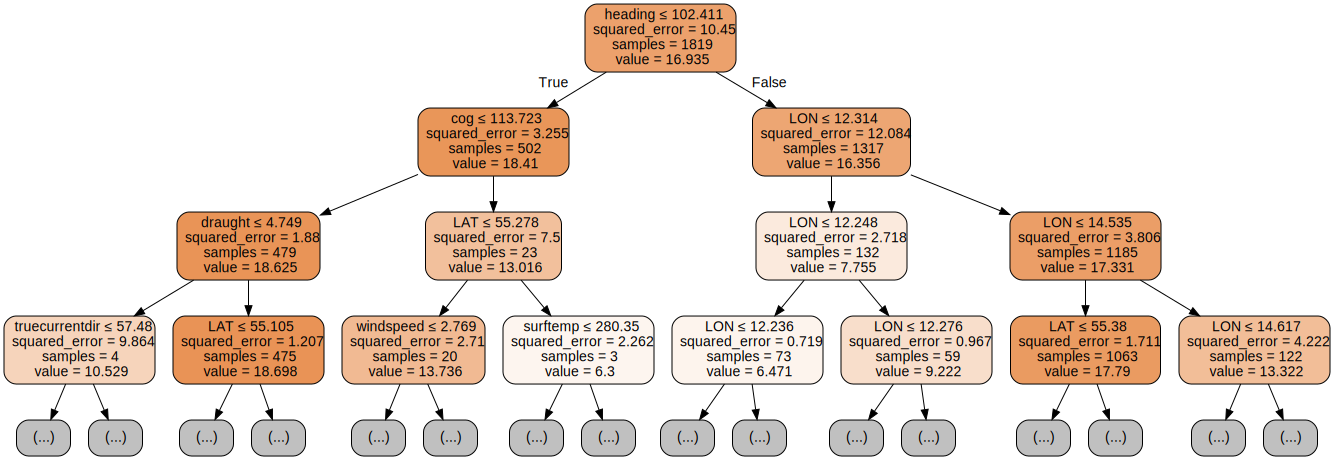

In [371]:
# Plot tree using graphviz, generate 1st tree in RFR (Graphviz must be installed in local computer)

from IPython.display import display
from sklearn import tree
import graphviz

dot_data_rfr = tree.export_graphviz(model_rfr_ftr_hpov.estimators_[1], 
                  feature_names=x_train.columns.values.tolist(),  
                #   class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                   max_depth=3,
                           )

display(graphviz.Source(dot_data_rfr))

# Only uncomment when about to generate PNG file, it will create source file that cannot be ignored by git

# graph = graphviz.Source(dot_data_rfr)
# graph.format = 'png'
# graph.render('rfr_mod_it1',view=True)

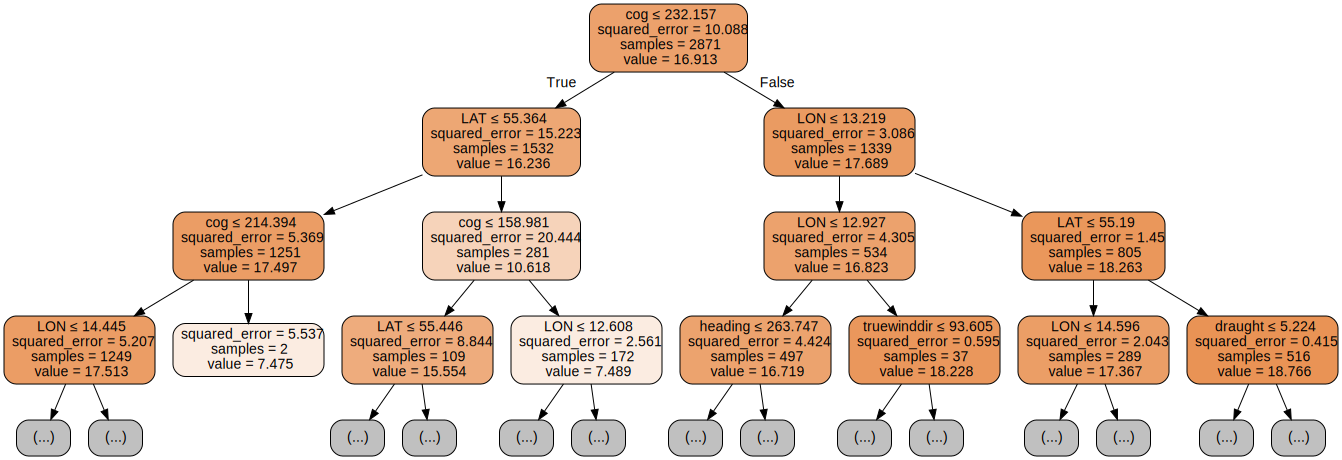

In [372]:
# Generate 1st tree in ETR

dot_data_etr = tree.export_graphviz(model_etr_hpov.estimators_[1], 
                  feature_names=x_train.columns.values.tolist(),  
                #   class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                   max_depth=3,
                           )

display(graphviz.Source(dot_data_etr))

# Only uncomment when about to generate PNG file, it will create source file that cannot be ignored by git

# graph = graphviz.Source(dot_data_etr)
# graph.format = 'png'
# graph.render('etr_mod_it1',view=True)

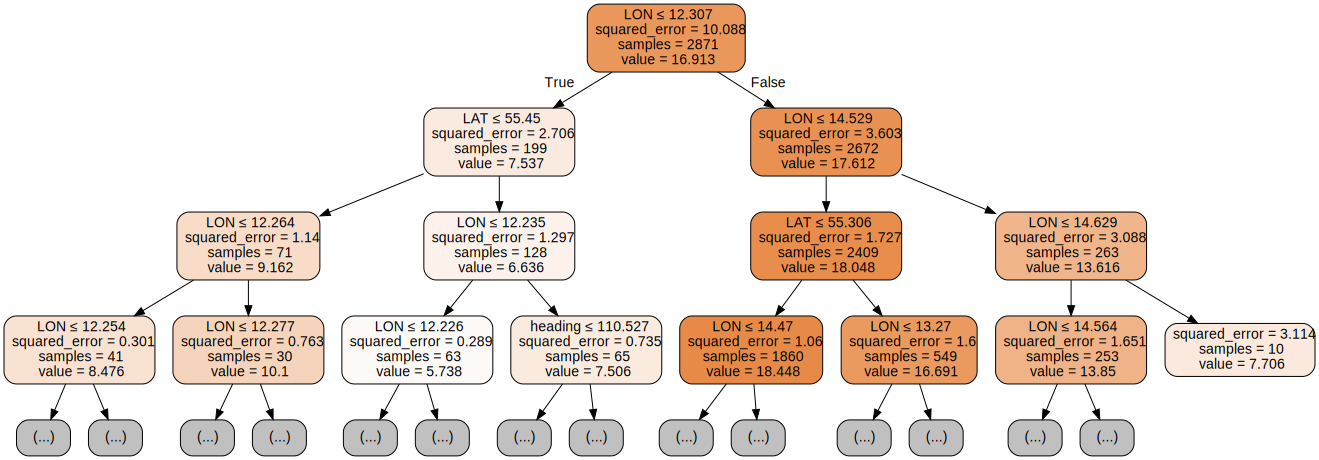

In [373]:
# Generate 1st tree in DTR

dot_data_dtr = tree.export_graphviz(model_dtr_hpov, 
                  feature_names=x_train.columns.values.tolist(),  
                #   class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                   max_depth=3,
                           )

display(graphviz.Source(dot_data_dtr))

# Only uncomment when about to generate PNG file, it will create source file that cannot be ignored by git

# graph = graphviz.Source(dot_data_dtr)
# graph.format = 'png'
# graph.render('dtr_mod_1tree',view=True)

### Feature importance 
+ Informally defined as how frequent the feature is used to split a node, [Sklearn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
+ Provide a good overview and it is an implicit feature selection post training

In [374]:
def model_importance(model_type):
    mod_imp = model_type.feature_importances_
    df_mod_imp = pd.DataFrame(mod_imp,index= x_train.columns,columns=["Importance"])
    print(df_mod_imp.sort_values(by=['Importance'],ascending=False))


In [375]:
# Plot feature importance of all features
def plot_feature_importance(model_type,names,model_name):

    importance = model_type.feature_importances_

    # #Create arrays from feature importance and feature names
    # feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Sort feature importances in ascending order
    sorted_indices = np.argsort(importance)
    sorted_feature_importances = importance[sorted_indices]
    sorted_feature_names = np.array(names)[sorted_indices]  # Replace with your actual feature names

    # Create a bar plot for sorted feature importances
    plt.figure(figsize=(10,6))
    plt.barh(range(len(sorted_feature_names)), sorted_feature_importances, color='black')
    plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
    plt.xlabel('Importance Value')
    plt.ylabel('Feature Name')
    plt.title(f'Feature Importances of {model_name}')
    plt.xlim(0,0.7)
    plt.grid(linestyle = '--', linewidth = 0.4,axis='x')
    plt.tight_layout()

    # Show importance values on the plot
    for i, v in enumerate(sorted_feature_importances):
        plt.text(v + 0.001, i, str(round(v, 4)), color='black', fontweight='bold')


In [376]:
# Plot feature importance without COG and heading 
def plot_feature_importance_norank(model_type,names,model_name):

    importance = model_type.feature_importances_

    # #Create arrays from feature importance and feature names
    # feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Sort feature importances in ascending order
    sorted_indices = np.argsort(importance)
    # Exclude the first and second-ranked features
    exclude_indices = [sorted_indices[10], sorted_indices[11]]
    remaining_indices = [i for i in sorted_indices if i not in exclude_indices]
    remaining_feature_importances = importance[remaining_indices]
    remaining_feature_names = [feature_names[i] for i in remaining_indices]

    # Sort the remaining feature importances in ascending order
    sorted_remaining_indices = np.argsort(remaining_feature_importances)
    sorted_feature_importances = remaining_feature_importances[sorted_remaining_indices]
    sorted_feature_names = [remaining_feature_names[i] for i in sorted_remaining_indices]


    # Create a bar plot for sorted feature importances
    plt.figure(figsize=(10,6))
    plt.barh(range(len(sorted_feature_names)), sorted_feature_importances, color='black')
    plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
    plt.xlabel('Importance Value')
    plt.ylabel('Feature Name')
    plt.title(f'Feature Importances of {model_name}')
    plt.xlim(0,0.025)
    plt.grid(linestyle = '--', linewidth = 0.4,axis='x')
    plt.tight_layout()

    # Show importance values on the plot
    for i, v in enumerate(sorted_feature_importances):
        plt.text(v + 0.001, i, str(round(v, 4)), color='black', fontweight='bold')


                     Importance
LON                    0.674127
LAT                    0.231042
cog                    0.032200
draught                0.017286
heading                0.017075
truecurrentdir         0.003597
curspeed               0.003349
surftemp               0.003311
truewavedir            0.003265
windwaveswellheight    0.003212
waveperiod             0.003068
windspeed              0.002936
truewinddir            0.002815
oceantemperature       0.002718


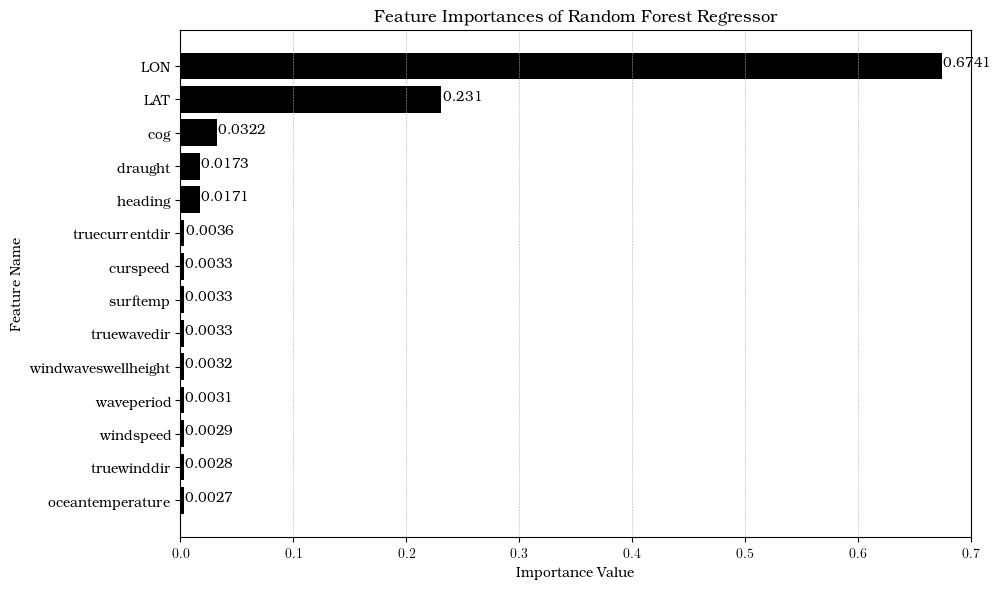

In [377]:
model_importance(model_rfr_ftr_hpov)
plot_feature_importance(model_rfr_ftr_hpov,x_train.columns,'Random Forest Regressor')
plt.show()


In [378]:
# plot_feature_importance_norank(model_rfr_ftr_hpov,x_train.columns,'Random Forest Regressor')
# plt.show()

                     Importance
LON                    0.385679
LAT                    0.358060
cog                    0.111574
heading                0.094857
draught                0.012169
truecurrentdir         0.011897
windwaveswellheight    0.006987
waveperiod             0.004772
curspeed               0.003579
surftemp               0.002390
windspeed              0.002279
truewavedir            0.002136
oceantemperature       0.001953
truewinddir            0.001670


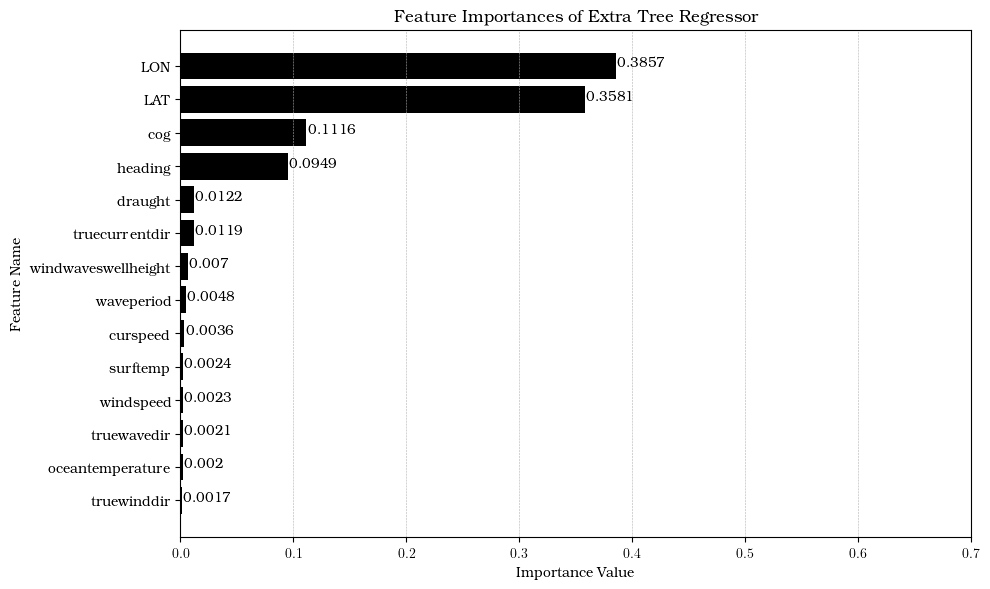

In [379]:
model_importance(model_etr_hpov)
plot_feature_importance(model_etr_hpov,x_train.columns,'Extra Tree Regressor')
plt.show()

In [380]:
# plot_feature_importance_norank(model_etr_hpov,x_train.columns,'Extra Tree Regressor')
# plt.show()

                     Importance
LON                    0.912765
LAT                    0.069201
draught                0.009502
cog                    0.005559
heading                0.001256
surftemp               0.000691
waveperiod             0.000458
oceantemperature       0.000246
truewinddir            0.000168
windwaveswellheight    0.000064
truewavedir            0.000057
truecurrentdir         0.000032
windspeed              0.000000
curspeed               0.000000


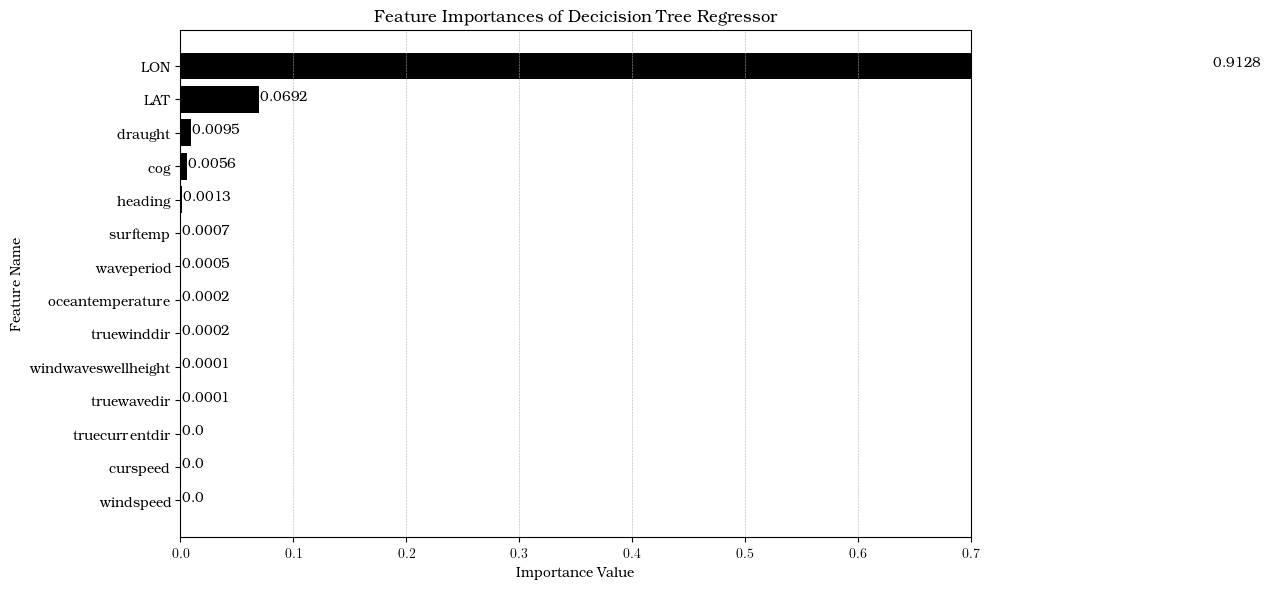

In [381]:
model_importance(model_dtr_hpov)
plot_feature_importance(model_dtr_hpov,x_train.columns,'Decicision Tree Regressor')
plt.show()

In [382]:
# plot_feature_importance_norank(model_dtr_hpov,x_train.columns,'Decicision Tree Regressor')
# plt.show()

### Cross validation evaluation of trained model
+ The model is subjected to 10-fold cross validation
+ The following metrics are used to evaluate the models
    + R<sup>2</sup>
    + explained Variance
    + MAE
    + RMSE
    + MAD

In [383]:
def evaluate(model, features_x, labels_y):
    from sklearn.model_selection import cross_val_score

    score_r2 = cross_val_score(model,features_x,labels_y,
                           scoring='r2',cv=10)
    rsquared = score_r2.mean()
    stadev_rsquared = score_r2.std()
    max_rsquared = score_r2.max()
    min_rsquared = score_r2.min()

    score_expVar = cross_val_score(model,features_x,labels_y,
                           scoring='explained_variance',cv=10)
    expVar = score_expVar.mean()
    stadev_expVar = score_expVar.std()
    max_expVar = score_expVar.max()
    min_expVar = score_expVar.min()

    score_MAE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_mean_absolute_error',cv=10)
    MAE = -score_MAE.mean()
    stadev_MAE = score_MAE.std()
    max_MAE = -score_MAE.max()
    min_MAE = -score_MAE.min()

    score_MAD = cross_val_score(model,features_x,labels_y,
                           scoring='neg_median_absolute_error',cv=10)
    MAD = -score_MAD.mean()
    stadev_MAD = score_MAD.std()
    max_MAD = -score_MAD.max()
    min_MAD = -score_MAD.min()



    score_MSE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_root_mean_squared_error',cv=10)
    score_RMSE = np.sqrt(-score_MSE)
    RMSE = score_RMSE.mean()
    stadev_RMSE = score_RMSE.std()
    max_RMSE = score_RMSE.max()
    min_RMSE = score_RMSE.min()


    print(f"Model Performance of {model}")
    print(f"R^2 = {rsquared:0.4f}, std = {stadev_rsquared:0.4f}, max = {max_rsquared:0.4f}, min = {min_rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}, std = {stadev_expVar:0.4f}, max = {max_expVar:0.4f}, min = {min_expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}, std = {stadev_MAE:0.4f}, max = {max_MAE:0.4f}, min = {min_MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}, std = {stadev_RMSE:0.4f}, max = {max_RMSE:0.4f}, min = {min_RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}, std = {stadev_MAD:0.4f}, max = {max_MAD:0.4f}, min = {min_MAD:0.4f}\n")

    return score_r2,score_expVar,score_MAE,score_RMSE,score_MAD        

Evaluation of RFR

In [384]:
r2_rf,expVar_rf,MAE_rf,RMSE_rf,MAD_rf = evaluate(model_rfr_ftr,x_train,y_train)

Model Performance of RandomForestRegressor(random_state=42)
R^2 = 0.9417, std = 0.0210, max = 0.9667, min = 0.9027
explained Variance = 0.9420, std = 0.0209, max = 0.9669, min = 0.9027
MAE = 0.4958, std = 0.0464, max = 0.4400, min = 0.5962
RMSE = 0.8610, std = 0.0695, max = 1.0277, min = 0.7719
MAD = 0.3468, std = 0.0245, max = 0.3089, min = 0.3776



In [385]:
# Optimised model performance

r2_rfo,expVar_rfo,MAE_rfo,RMSE_rfo,MAD_rfo = evaluate(model_rfr_ftr_hpov,x_train,y_train)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 = 0.9431, std = 0.0193, max = 0.9672, min = 0.9083
explained Variance = 0.9434, std = 0.0191, max = 0.9674, min = 0.9083
MAE = 0.4957, std = 0.0437, max = 0.4368, min = 0.5871
RMSE = 0.8572, std = 0.0641, max = 1.0127, min = 0.7842
MAD = 0.3501, std = 0.0240, max = 0.3190, min = 0.3885



Evaluation of ETR

In [386]:
r2_et,expVar_et,MAE_et,RMSE_et,MAD_et = evaluate(model_etr,x_train,y_train)

Model Performance of ExtraTreesRegressor(random_state=42)
R^2 = 0.9537, std = 0.0101, max = 0.9650, min = 0.9325
explained Variance = 0.9539, std = 0.0100, max = 0.9652, min = 0.9332
MAE = 0.4661, std = 0.0304, max = 0.4288, min = 0.5278
RMSE = 0.8201, std = 0.0423, max = 0.9129, min = 0.7646
MAD = 0.3335, std = 0.0206, max = 0.2993, min = 0.3643



In [387]:
# Optimised model performance 

r2_eto,expVar_eto,MAE_eto,RMSE_eto,MAD_eto = evaluate(model_etr_hpov,x_train,y_train)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 = 0.9485, std = 0.0142, max = 0.9623, min = 0.9184
explained Variance = 0.9488, std = 0.0142, max = 0.9625, min = 0.9184
MAE = 0.4781, std = 0.0400, max = 0.4344, min = 0.5576
RMSE = 0.8406, std = 0.0601, max = 0.9837, min = 0.7685
MAD = 0.3409, std = 0.0335, max = 0.2969, min = 0.4169



Evaluation of DTR

In [388]:
r2_dt,expVar_dt,MAE_dt,RMSE_dt,MAD_dt = evaluate(model_dtr,x_train,y_train)

Model Performance of DecisionTreeRegressor()
R^2 = 0.8891, std = 0.0293, max = 0.9362, min = 0.8494
explained Variance = 0.8932, std = 0.0312, max = 0.9316, min = 0.8312
MAE = 0.6837, std = 0.0419, max = 0.6035, min = 0.7566
RMSE = 1.0043, std = 0.0519, max = 1.0955, min = 0.9136
MAD = 0.5099, std = 0.0279, max = 0.4738, min = 0.5522



In [389]:
# Optimised model performance

r2_dto,expVar_dto,MAE_dto,RMSE_dto,MAD_dto = evaluate(model_dtr_hpov,x_train,y_train)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 = 0.9130, std = 0.0248, max = 0.9434, min = 0.8665
explained Variance = 0.9189, std = 0.0231, max = 0.9475, min = 0.8770
MAE = 0.5878, std = 0.0545, max = 0.5116, min = 0.6948
RMSE = 0.9595, std = 0.0768, max = 1.1456, min = 0.8736
MAD = 0.4218, std = 0.0302, max = 0.3727, min = 0.4633



Evaluation of MLR 

In [390]:
r2_mlr,expVar_mlr,MAE_mlr,RMSE_mlr,MAD_mlr = evaluate(model_mlr,x_train,y_train)

Model Performance of LinearRegression()
R^2 = 0.7284, std = 0.0706, max = 0.8083, min = 0.5883
explained Variance = 0.7289, std = 0.0705, max = 0.8083, min = 0.5886
MAE = 1.0707, std = 0.0617, max = 0.9751, min = 1.1890
RMSE = 1.2741, std = 0.0798, max = 1.4741, min = 1.1835
MAD = 0.8136, std = 0.0504, max = 0.7436, min = 0.8851



In [392]:
def evaluate_SOG(model,x_date,y_date):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    def label_predict(model,test_features):
        predictions = model.predict(test_features)
        return predictions
    
    predictions = label_predict(model,x_date)

    Rsquared_SOG = r2_score(y_date,predictions)
    expVar_SOG = explained_variance_score(y_date,predictions)
    MAE_SOG = mean_absolute_error(y_date,predictions)
    RMSE_SOG = np.sqrt(mean_squared_error(y_date, predictions))
    MAD_SOG = median_absolute_error(y_date,predictions)
    MAPE_SOG = mean_absolute_percentage_error(y_date, predictions)
    

    print(f"Model Performance of {model}")
    print(f"R^2 SOG = {Rsquared_SOG:0.4f}")
    print(f"Explained Variance SOG = {expVar_SOG:0.4f}")
    print(f"MSE SOG = {MAE_SOG:0.4f} Knots")    
    print(f"RMSE SOG = {RMSE_SOG:0.4f} Knots")
    print(f"MAD SOG = {MAD_SOG:0.4f} Knots")    
    print(f"MAPE SOG = {MAPE_SOG*100:0.4f} %")

In [393]:
evaluate_SOG(model_rfr_ftr,x_test,y_test)

Model Performance of RandomForestRegressor(random_state=42)
R^2 SOG = 0.9461
Explained Variance SOG = 0.9462
MSE SOG = 0.4481 Knots
RMSE SOG = 0.7188 Knots
MAD SOG = 0.3312 Knots
MAPE SOG = 2.9039 %


In [394]:
evaluate_SOG(model_etr_hpov,x_test,y_test)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9449
Explained Variance SOG = 0.9449
MSE SOG = 0.4572 Knots
RMSE SOG = 0.7268 Knots
MAD SOG = 0.3300 Knots
MAPE SOG = 3.0287 %


In [391]:
stp

NameError: name 'stp' is not defined

### Learning Curves
+ Helps to identify the benefits of performing HPO
+ At certain point, not tangible performance gain can be obtained

In [ ]:
# Parameter to reset plot properties to default and change the font to tex

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

In [ ]:
# Functions for MAE and Rsquared plots for learning curve

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit ,learning_curve

def learn_plotrmse(model,x_data,y_data,model_name):
    train_sizes, train_scores, test_scores = learning_curve(estimator = model, X=x_data, y=y_data,
                                                        cv=10, train_sizes=np.linspace(0.1, 1.0, 20),
                                                        n_jobs=-1,scoring="neg_mean_absolute_error")
	# Parameter to plot in nice latex fonts
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    #
    # Calculate training and test mean and std
    #
    train_scores = np.sqrt(-train_scores)
    test_scores = np.sqrt(-test_scores)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    #
    # Plot the learning curve
    #
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label=r'Training Error')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='d', markersize=5, linestyle='--', label=r'Validation Error')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(fr'Learning Curve of {model_name}')
    plt.xlabel(r'Training Data Size')
    plt.ylabel(r'MAE [knots]')
    plt.xlim(200,2700)
    plt.ylim(0,2)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(loc='lower right')
    # plt.show()
    
def learn_plotr2(model,x_data,y_data,model_name):
    train_sizes, train_scores, test_scores = learning_curve(estimator = model, X=x_data, y=y_data,
                                                        cv=10, train_sizes=np.linspace(0.1, 1.0,20),
                                                        n_jobs=-1,scoring="r2")
	# Parameter to plot in nice latex fonts
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    #
    # Calculate training and test mean and std
    #
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    #
    # Plot the learning curve
    #
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label=r'Training Score')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='d', markersize=5, linestyle='--', label=r'Validation Score')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(fr'Learning Curve of {model_name}')
    plt.xlabel(r'Training Data Size')
    plt.ylabel(r'Rsquared')
    plt.ylim(0.5,1)
    plt.xlim(200,2700)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(loc='lower right')
    # plt.show()


Understanding Effect of Hyperparameter optimisation

Learning Curve DTR

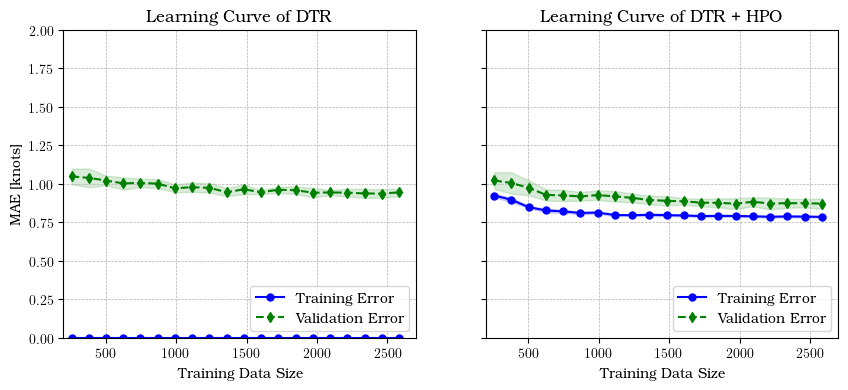

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotrmse(model_dtr,x_train,y_train,'DTR')
plt.sca(axes[1])
learn_plotrmse(model_dtr_hpov,x_train,y_train,'DTR + HPO')
plt.ylabel("")
plt.show()

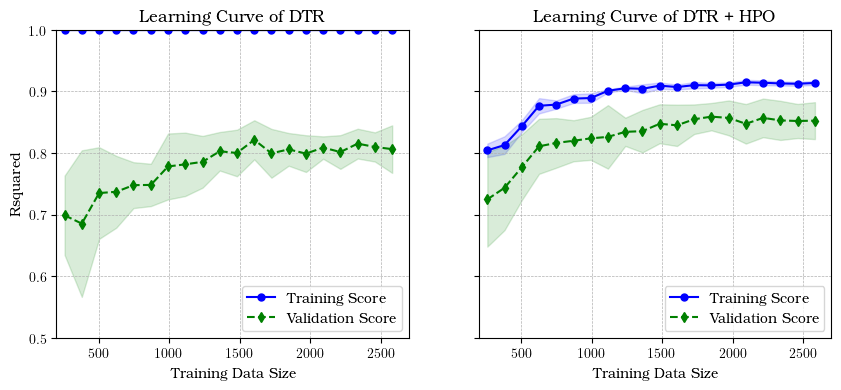

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotr2(model_dtr,x_train,y_train,'DTR')
plt.sca(axes[1])
learn_plotr2(model_dtr_hpov,x_train,y_train,'DTR + HPO')
plt.ylabel("")
plt.show()

Learning Curve RFR

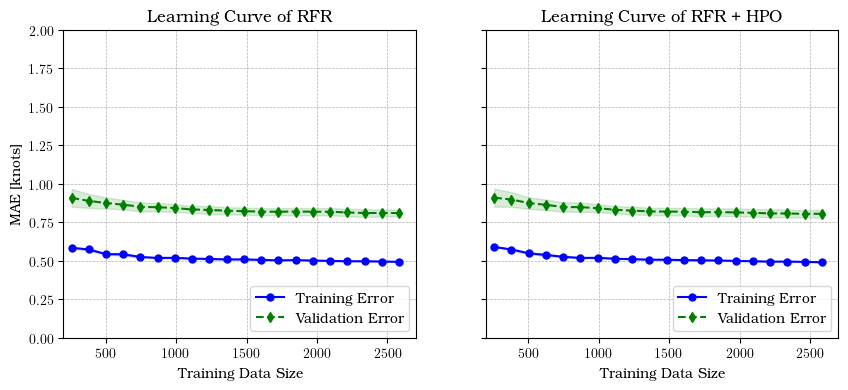

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotrmse(model_rfr_ftr,x_train,y_train,'RFR')
plt.sca(axes[1])
learn_plotrmse(model_rfr_ftr_hpov,x_train,y_train,'RFR + HPO')
plt.ylabel("")
plt.show()

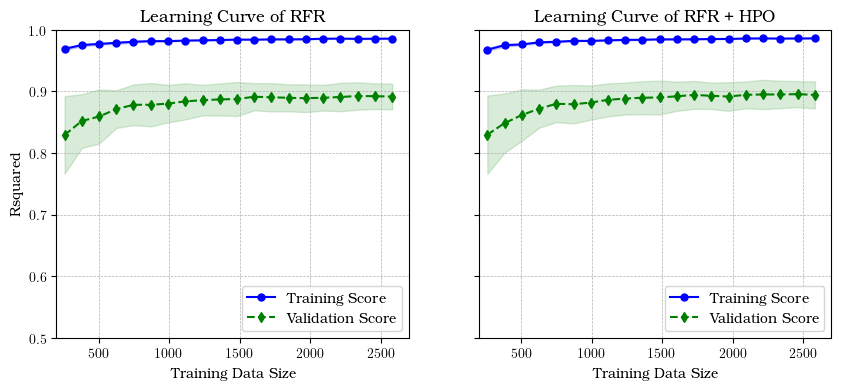

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotr2(model_rfr_ftr,x_train,y_train,'RFR')
plt.sca(axes[1])
learn_plotr2(model_rfr_ftr_hpov,x_train,y_train,'RFR + HPO')
plt.ylabel("")
plt.show()

Learning Curve ETR

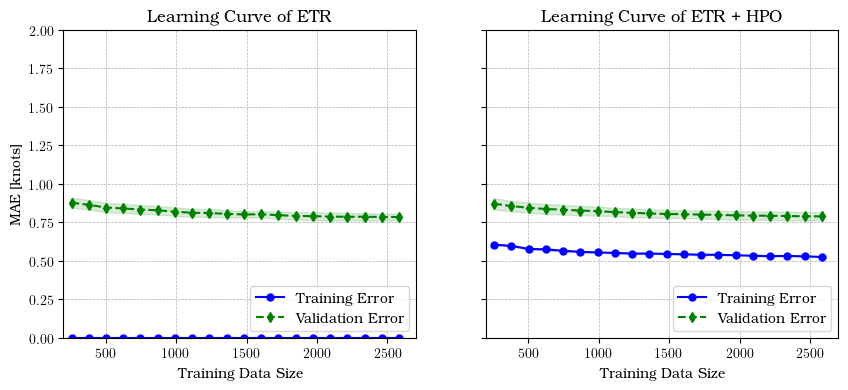

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotrmse(model_etr,x_train,y_train,'ETR')
plt.sca(axes[1])
learn_plotrmse(model_etr_hpov,x_train,y_train,'ETR + HPO')
plt.ylabel("")
plt.show()

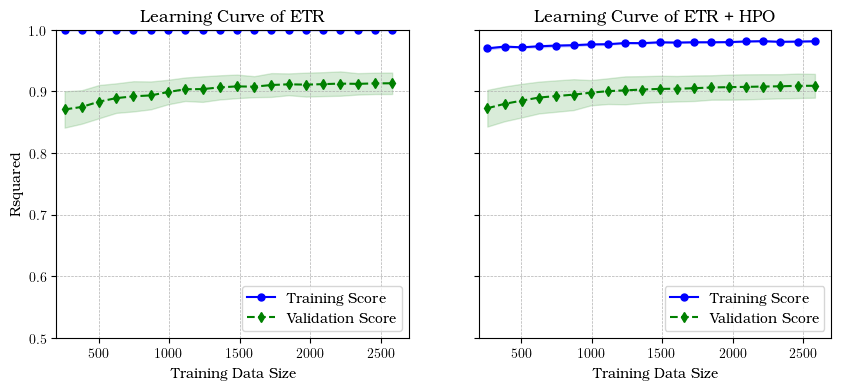

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotr2(model_etr,x_train,y_train,'ETR')
plt.sca(axes[1])
learn_plotr2(model_etr_hpov,x_train,y_train,'ETR + HPO')
plt.ylabel("")
plt.show()

### Boxplots of the k-Fold evaluations

<Figure size 500x300 with 0 Axes>

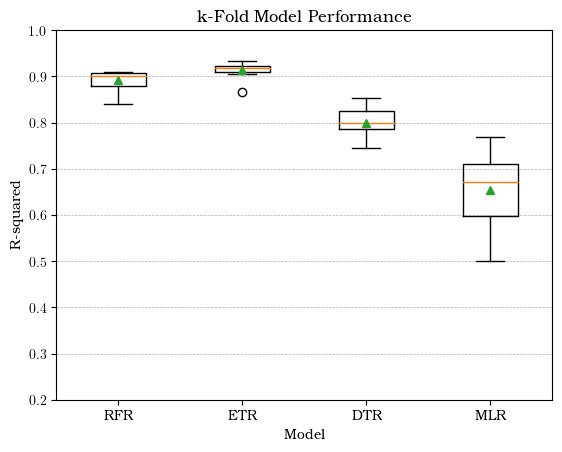

In [ ]:
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [r2_rf,r2_et,r2_dt,r2_mlr]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("k-Fold Model Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0.2,1.0)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR', 'MLR'])
plt.show()

<Figure size 500x300 with 0 Axes>

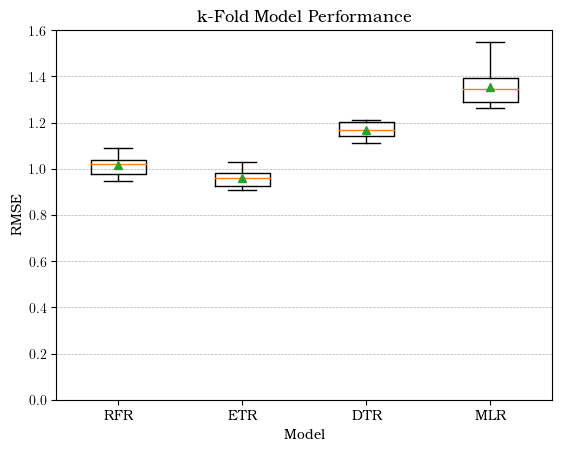

In [ ]:
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores_rmse = [np.abs(RMSE_rf),np.abs(RMSE_et),np.abs(RMSE_dt),np.abs(RMSE_mlr)]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("k-Fold Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.ylim(0,1.6)
plt.yscale('linear')
ax.boxplot(scores_rmse,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR', 'MLR'])
plt.show()

Comparison for optimised model

In [ ]:
def r2_plot_opt(r2_mod1,r2_mod1opt,r2_mod2,r2_mod2opt,r2_mod3,r2_mod3opt):
    scores_opt = [r2_mod1,r2_mod1opt,r2_mod2,r2_mod2opt,r2_mod3,r2_mod3opt]
    # fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("k-Fold Model Performance")
    plt.ylabel("R-squared")
    plt.xlabel("Model")
    plt.ylim(0.2,1.0)
    plt.yscale('linear')
    ax.boxplot(scores_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                        r'ETR', r'$ETR_{opt}$',
                        r'DTR',r'$DTR_{opt}$'])

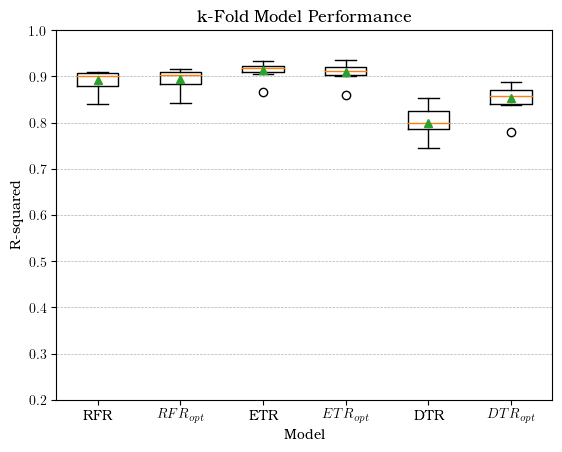

In [ ]:
r2_plot_opt(r2_rf,r2_rfo,r2_et,r2_eto,r2_dt,r2_dto)
plt.show()

In [ ]:
def rmse_plot_opt(rmse_mod1,rmse_mod1opt,rmse_mod2,rmse_mod2opt,rmse_mod3,rmse_mod3opt):
    rmse_opt = [rmse_mod1,rmse_mod1opt,rmse_mod2,rmse_mod2opt,rmse_mod3,rmse_mod3opt]
    # fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("k-Fold Model Performance")
    plt.ylabel("RMSE [knots]")
    plt.xlabel("Model")
    plt.yscale('linear')
    plt.ylim(0,1.4)
    ax.boxplot(rmse_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                        r'ETR', r'$ETR_{opt}$',
                        r'DTR',r'$DTR_{opt}$'])

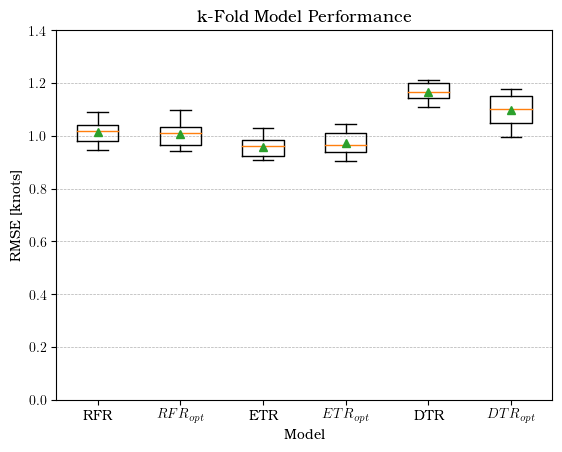

In [ ]:
rmse_plot_opt(RMSE_rf,RMSE_rfo,RMSE_et,RMSE_eto,RMSE_dt,RMSE_dto)
plt.show()


In [ ]:
def mae_plot_opt(mae_mod1,mae_mod1opt,mae_mod2,mae_mod2opt,mae_mod3,mae_mod3opt):
    mae_opt = [mae_mod1,mae_mod1opt,mae_mod2,mae_mod2opt,mae_mod3,mae_mod3opt]
    fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("k-Fold Model Performance")
    plt.ylabel("MAE [knots]")
    plt.xlabel("Model")
    plt.yscale('linear')
    plt.ylim(0,1.4)
    ax.boxplot(mae_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                        r'ETR', r'$ETR_{opt}$',
                        r'DTR',r'$DTR_{opt}$'])

<Figure size 500x300 with 0 Axes>

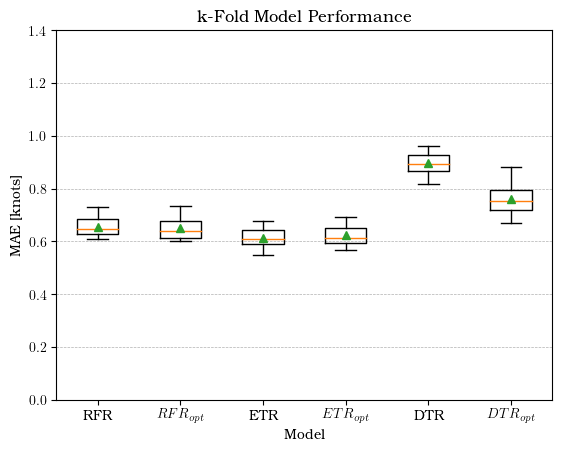

In [ ]:
mae_plot_opt(-MAE_rf,-MAE_rfo,-MAE_et,-MAE_eto,-MAE_dt,-MAE_dto)
plt.show()

In [ ]:
def mad_plot_opt(mad_mod1,mad_mod1opt,mad_mod2,mad_mod2opt,mad_mod3,mad_mod3opt):
    mad_opt = [mad_mod1,mad_mod1opt,mad_mod2,mad_mod2opt,mad_mod3,mad_mod3opt]
    fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("k-Fold Model Performance")
    plt.ylabel("MAD [knots]")
    plt.xlabel("Model")
    plt.yscale('linear')
    plt.ylim(0,1.4)
    ax.boxplot(mad_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                        r'ETR', r'$ETR_{opt}$',
                        r'DTR',r'$DTR_{opt}$'])

<Figure size 500x300 with 0 Axes>

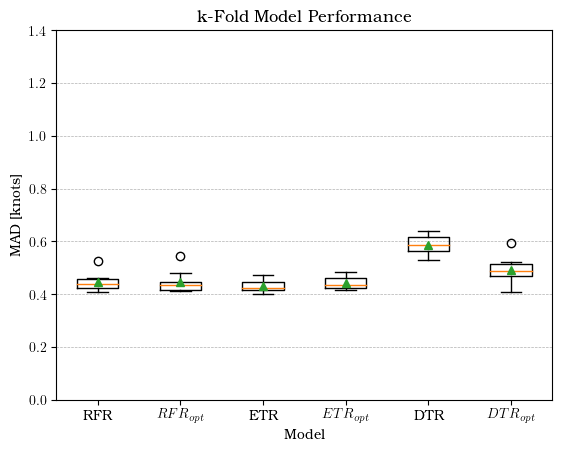

In [ ]:
mad_plot_opt(-MAD_rf,-MAD_rfo,-MAD_et,-MAD_eto,-MAD_dt,-MAD_dto)
plt.show()